In [60]:
import json
import requests
import datetime as dt
import numpy as np
import pandas as pd
# defining key/request url
from binance.client import Client
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import sklearn
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
#Getting data for last year with 1h interval

In [3]:
api_key='hKmlFuyZiyNlaN6ARvCKnhF5owS6yrVJolMeSBfThE5Hc6L26aRM2Z3N8EuVQf0y'
secret_key='B4c5Cr9vwsubR19XK05axHk6aSGhnP91GdXLY57LlaYoUNMf4s5egKIHhtgfJYAd'

In [5]:
client = Client(api_key, secret_key)

In [12]:
df= pd.DataFrame(client.get_historical_klines('BTCUSDT','1h',
                                              str((dt.datetime.now() - dt.timedelta(weeks=52))),
                                              str((dt.datetime.now()))))
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,1658235600000,22175.50000000,22440.67000000,22041.45000000,22320.63000000,13736.46489000,1658239199999,305499532.93059590,317526,6485.01262000,144199574.91105730,0
1,1658239200000,22317.63000000,22640.12000000,22101.40000000,22626.42000000,11572.98005000,1658242799999,258389985.51461890,305565,5853.29926000,130725594.85511700,0
2,1658242800000,22626.18000000,23199.90000000,22461.05000000,23136.08000000,29208.75727000,1658246399999,667235788.62900640,576710,15012.10459000,343042844.16600580,0
3,1658246400000,23128.31000000,23441.38000000,22950.21000000,23234.23000000,22425.39036000,1658249999999,520753416.52460640,444781,11079.61686000,257371299.89108550,0
4,1658250000000,23236.66000000,23529.00000000,23072.22000000,23460.08000000,11702.10720000,1658253599999,272247593.46236530,269603,5968.30040000,138898588.47166150,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8727,1689656400000,30118.19000000,30118.19000000,30040.00000000,30052.22000000,530.88448000,1689659999999,15966523.65832150,15061,206.80220000,6219571.96239300,0
8728,1689660000000,30052.23000000,30097.09000000,29921.54000000,29988.62000000,1388.90380000,1689663599999,41675613.30831250,40673,610.27999000,18312443.03537770,0
8729,1689663600000,29988.61000000,30040.39000000,29926.70000000,29968.13000000,1151.28365000,1689667199999,34538276.60889080,27294,589.87374000,17698080.38328450,0
8730,1689667200000,29968.13000000,30111.68000000,29881.00000000,30021.99000000,1610.96253000,1689670799999,48321422.38399060,40869,733.31672000,21997629.01351770,0


In [13]:
df.columns=['open_time','open','high','low','close','volume',
           'close_time','q_vol','trades','taker_buy_volume',
            'taker_q_volume','ignored']

In [14]:
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['close_time'] = pd.to_datetime(df['open_time'], unit='ms')

In [15]:
df = df.set_index('open_time')

In [19]:
df['const'] = np.ones(len(df))

In [16]:
df['trend'] = np.arange(len(df))
df['time'] = df.index 
df=df.drop('close_time',axis=1)
df=df.astype(np.float32,errors='ignore')
df

,open,high,low,close,volume,q_vol,trades,taker_buy_volume,taker_q_volume,ignored,trend,time
open_time,,,,,,,,,,,,
2022-07-19 13:00:00,22175.500000,22440.669922,22041.449219,22320.630859,13736.464844,305499520.0,317526.0,6485.012695,144199568.0,0.0,0.0,2022-07-19 13:00:00
2022-07-19 14:00:00,22317.630859,22640.119141,22101.400391,22626.419922,11572.980469,258389984.0,305565.0,5853.299316,130725592.0,0.0,1.0,2022-07-19 14:00:00
2022-07-19 15:00:00,22626.179688,23199.900391,22461.050781,23136.080078,29208.757812,667235776.0,576710.0,15012.104492,343042848.0,0.0,2.0,2022-07-19 15:00:00
2022-07-19 16:00:00,23128.310547,23441.380859,22950.210938,23234.230469,22425.390625,520753408.0,444781.0,11079.617188,257371296.0,0.0,3.0,2022-07-19 16:00:00
2022-07-19 17:00:00,23236.660156,23529.000000,23072.220703,23460.080078,11702.107422,272247584.0,269603.0,5968.300293,138898592.0,0.0,4.0,2022-07-19 17:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-18 05:00:00,30118.189453,30118.189453,30040.000000,30052.220703,530.884460,15966524.0,15061.0,206.802200,6219572.0,0.0,8727.0,2023-07-18 05:00:00
2023-07-18 06:00:00,30052.230469,30097.089844,29921.539062,29988.619141,1388.903809,41675612.0,40673.0,610.279968,18312444.0,0.0,8728.0,2023-07-18 06:00:00
2023-07-18 07:00:00,29988.609375,30040.390625,29926.699219,29968.130859,1151.283691,34538276.0,27294.0,589.873718,17698080.0,0.0,8729.0,2023-07-18 07:00:00


<Axes: xlabel='time', ylabel='open'>

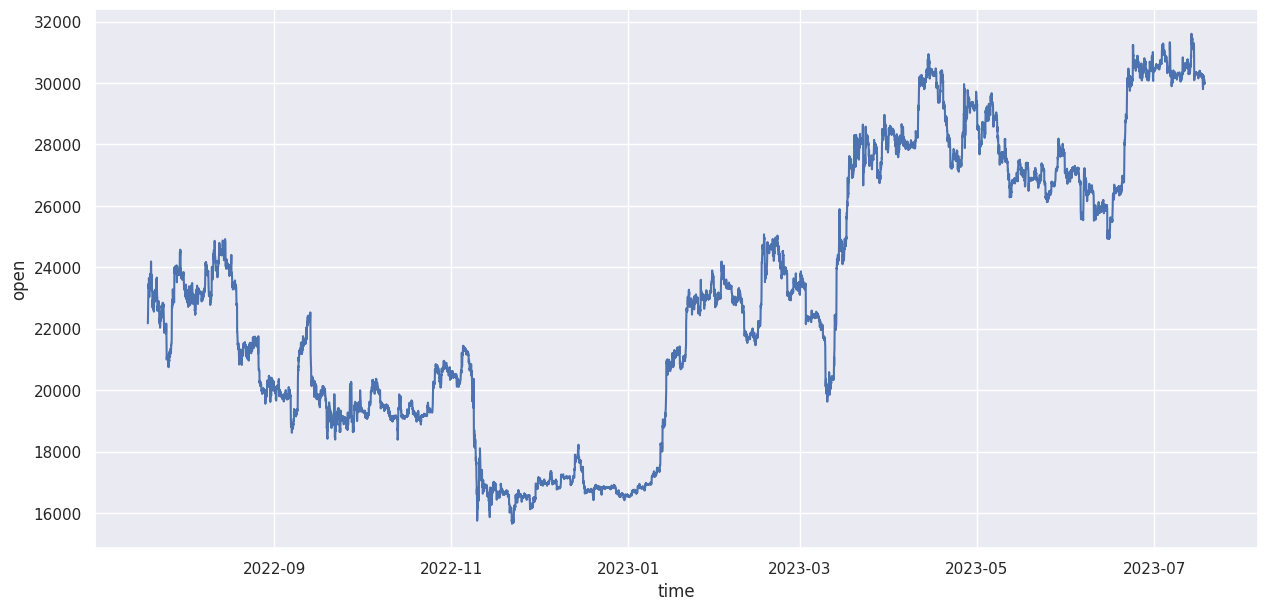

In [17]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=df,x='time',y='open')

In [21]:
#correlation between trades and open price

<Axes: xlabel='open', ylabel='trades'>

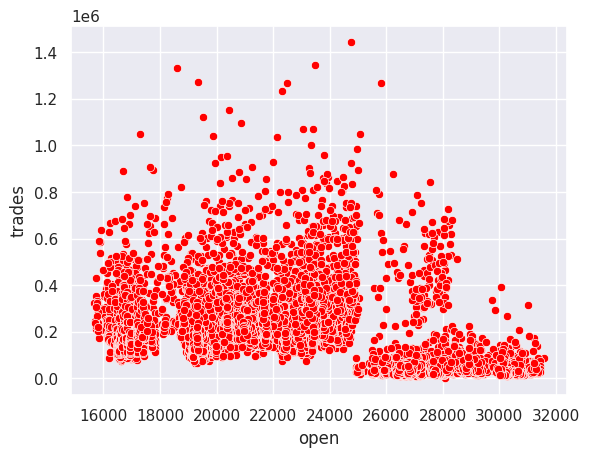

In [23]:
sns.scatterplot(data=df, x='open',y='trades',c='red')

In [18]:
#CREATING TIME TREND FEATURE

In [45]:
df['trend_2']=df.trend**2
df['trend_3']=df.trend**3
df['trend_4']=df.trend**4
X_time_trend=df[['trend','trend_2','trend_3','trend_4']]
y=df['open']

In [46]:
y_dummy = np.ones(len(y))*y.mean()

In [52]:
def check_model_full(model, X, y):
    model.fit(X, y)
    y_pred_1 = model_1.predict(X)
    print(f'r2 {r2_score(y,y_pred_1)}, absolute {mean_absolute_error(y,y_pred_1)}')
    sns.lineplot(data=df,x='time',y='open')
    sns.lineplot(x=df.time,y=y_pred_1,c='red')

/home/kilka/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.481e+10, tolerance: 1.722e+07
  model = cd_fast.enet_coordinate_descent(


r2 0.6752743271379984, absolute 2015.07373046875


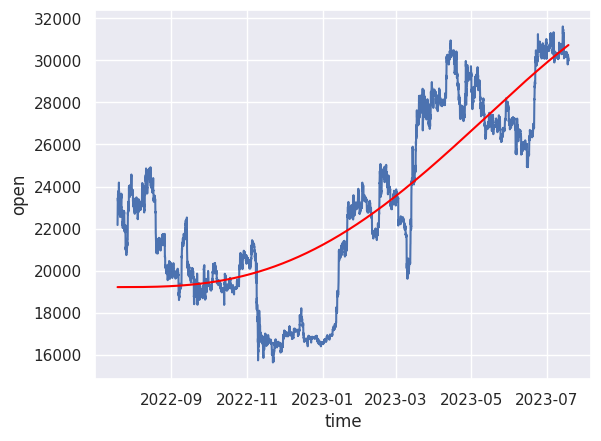

In [54]:
check_model_full(Lasso(), X_time_trend, y)

r2 0.6752743271379984, absolute 2015.07373046875


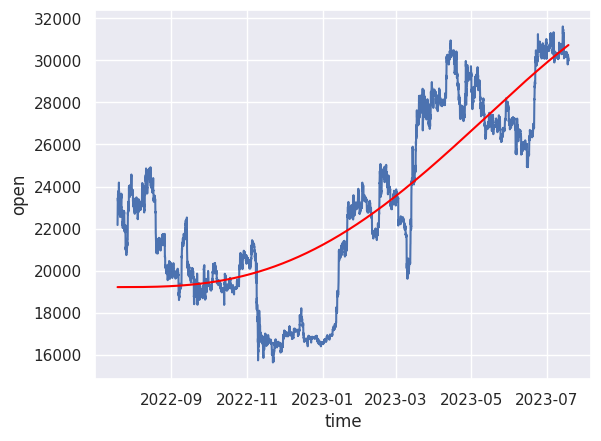

In [65]:
check_model_full(XGBRegressor(n_estimators=2, max_depth=5, learning_rate=1), X_time_trend, y)

In [49]:
#CREATE MOVING AVERAGE

In [78]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    return rolling_mean

In [ ]:
#weekly 

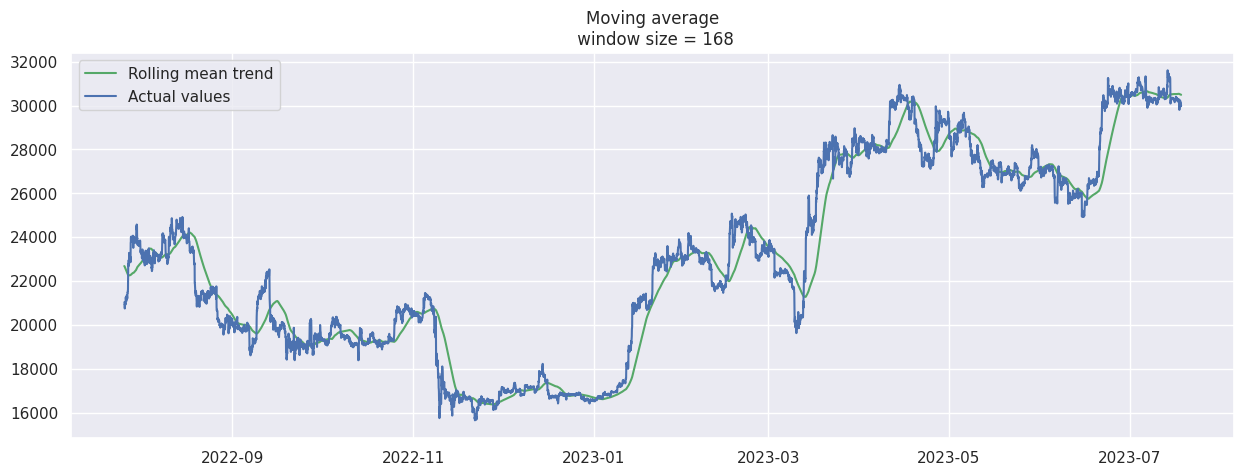

In [91]:
days=7
mov_av = plotMovingAverage(y,24*days)

In [88]:
print(f'r2 {r2_score(y[24*days:],mov_av[24*5:])}, absolute {mean_absolute_error(y[24*5:],mov_av[24*5:])}')

r2 0.9677337581672785, absolute 545.1848626008767
